In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import random

import math
import re
from typing import Iterable, Dict, Optional, Tuple, List

from torch.nn.functional import softmax
from tqdm import tqdm

from utils import set_seed, load_data, plot_stability, plot_comprehensiveness, plot_sufficiency
from token_score import get_attention_score, get_lime_score
from eval_stability import stability
from eval_faithfulness import comprehensiveness, sufficiency

c:\Users\Mai\miniconda3\envs\nlp_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seed()
    
imdb_path = 'sampled/imdb_sampled_500.pkl'
sst2_path = 'sampled/sst2_sampled_436.pkl'

imdb_df = load_data(imdb_path).iloc[:5]
sst2_df = load_data(sst2_path).iloc[:5]

Loaded samples from: sampled/imdb_sampled_500.pkl
Loaded samples from: sampled/sst2_sampled_436.pkl


In [3]:
# Example ratios
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Dataset configs ---
datasets = {
    "SST2": {
        "data": sst2_df,
        "models": {
            "TinyBERT": "D:/master/NLP/models/tinybert_sst2/final",
            "DistilBERT": "D:/master/NLP/models/distilbert_sst2/final",
            "ALBERT": "D:/master/NLP/models/albert_sst2/final",
        },
    },
    "IMDB": {
        "data": imdb_df,
        "models": {
            "TinyBERT": "D:/master/NLP/models/tinybert_imdb/final",
            "DistilBERT": "D:/master/NLP/models/distilbert_imdb/final",
            "ALBERT": "D:/master/NLP/models/albert_imdb/final",
        },
    },
}

# Get token important score

In [3]:
# Attention Score 

model_dir = "D:/master/NLP/models/tinybert_sst2/final"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

text = "The movie was absolutely fantastic!"
tokens, scores = get_attention_score(text, tokenizer, model, device=device)
for t, s in zip(tokens, scores):
    print(f"{t:>12s} : {s:.4f}")

       [CLS] : 0.1992
         the : 0.0230
       movie : 0.0402
         was : 0.0428
  absolutely : 0.0471
   fantastic : 0.0870
           ! : 0.0470
       [SEP] : 0.5137


In [4]:
text = "The movie was absolutely fantastic and full of emotion."
tokens, scores = get_lime_score(text, tokenizer, model)

for t, s in zip(tokens, scores):
    print(f"{t:<15} {s:.4f}")

The             0.0401
movie           0.0145
was             0.0749
absolutely      0.2054
fantastic       0.2582
and             0.0724
full            0.1416
of              0.0440
emotion         0.1490
.               0.0000


# Stability

In [6]:
RATIOS = [0.01, 0.05, 0.10, 0.20, 0.50]


=== Processing SST2 ===

===== Running stability for TinyBERT (SST2) =====


100%|██████████| 5/5 [00:00<00:00, 15.76it/s]



===== Running stability for DistilBERT (SST2) =====


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]



===== Running stability for ALBERT (SST2) =====


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


       p  corr_spearman_mean       model
0   0.01            1.000000    TinyBERT
1   0.05            1.000000    TinyBERT
2   0.10            0.967671    TinyBERT
3   0.20            0.940339    TinyBERT
4   0.50            0.671143    TinyBERT
5   0.01            1.000000  DistilBERT
6   0.05            1.000000  DistilBERT
7   0.10            0.963076  DistilBERT
8   0.20            0.913660  DistilBERT
9   0.50            0.701187  DistilBERT
10  0.01            1.000000      ALBERT
11  0.05            1.000000      ALBERT
12  0.10            0.883240      ALBERT
13  0.20            0.684895      ALBERT
14  0.50            0.614402      ALBERT
Figure saved to eval_plot/SST2_stability.png


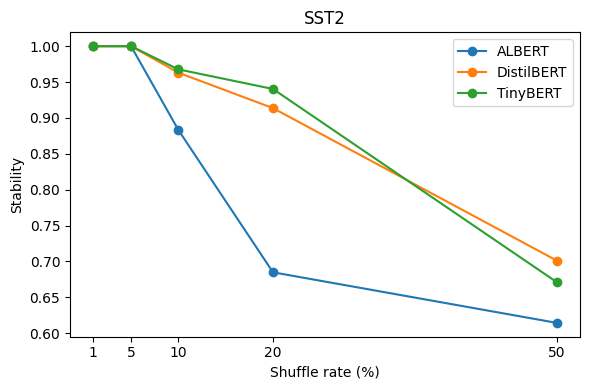


=== Processing IMDB ===

===== Running stability for TinyBERT (IMDB) =====


100%|██████████| 5/5 [00:01<00:00,  4.27it/s]



===== Running stability for DistilBERT (IMDB) =====


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]



===== Running stability for ALBERT (IMDB) =====


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]

       p  corr_spearman_mean       model
0   0.01            1.000000    TinyBERT
1   0.05            0.834204    TinyBERT
2   0.10            0.690368    TinyBERT
3   0.20            0.554545    TinyBERT
4   0.50            0.404431    TinyBERT
5   0.01            1.000000  DistilBERT
6   0.05            0.799567  DistilBERT
7   0.10            0.688558  DistilBERT
8   0.20            0.550885  DistilBERT
9   0.50            0.270972  DistilBERT
10  0.01            0.998000      ALBERT
11  0.05            0.798052      ALBERT
12  0.10            0.695843      ALBERT
13  0.20            0.474665      ALBERT
14  0.50            0.284990      ALBERT
Figure saved to eval_plot/IMDB_stability.png


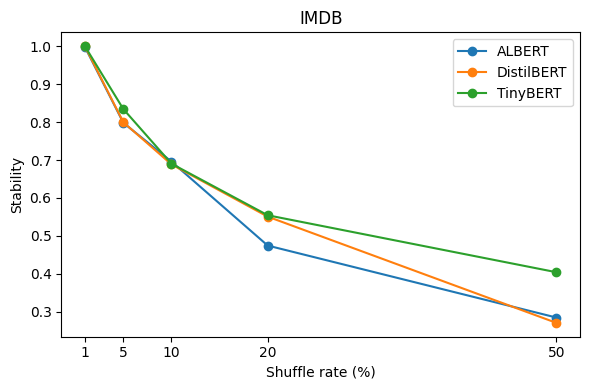

In [ ]:
# --- Run stability for all datasets ---
method = 'Attention'
get_importance_fn = get_attention_score  # or get_lime_score, etc.

for dataset_name, cfg in datasets.items():
    print(f"\n=== Processing {dataset_name} ===")
    all_results = []

    for model_name, model_dir in cfg["models"].items():
        print(f"\n===== Running stability for {model_name} ({dataset_name}) =====")

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)
        model.to(device).eval()

        stability_df = stability(
            cfg["data"],
            tokenizer,
            model,
            get_importance_fn,
            RATIOS,
            device,
        )

        stability_df["model"] = model_name
        stability_df.rename(columns={"ratio": "p", "mean_spearman": "corr_spearman_mean"}, inplace=True)
        all_results.append(stability_df)

    # --- Combine and plot ---
    final_results = pd.concat(all_results, ignore_index=True)
    final_results.to_scv(f"{data_name}_stability_{method}.csv")
    print(final_results)

    plot_stability(final_results, RATIOS, title=f"{method}_{dataset_name}")


# Comprehensiveness


=== Processing SST2 ===

===== Running comprehensiveness for TinyBERT (SST2) =====


100%|██████████| 5/5 [00:00<00:00, 16.72it/s]



===== Running comprehensiveness for DistilBERT (SST2) =====


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]



===== Running comprehensiveness for ALBERT (SST2) =====


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

       p  comp_mean       model
0   0.01   0.493826    TinyBERT
1   0.05   0.493826    TinyBERT
2   0.10   0.595635    TinyBERT
3   0.20   0.656520    TinyBERT
4   0.50   0.823105    TinyBERT
5   0.01   0.322198  DistilBERT
6   0.05   0.322198  DistilBERT
7   0.10   0.322545  DistilBERT
8   0.20   0.513538  DistilBERT
9   0.50   0.409195  DistilBERT
10  0.01   0.453261      ALBERT
11  0.05   0.553654      ALBERT
12  0.10   0.584085      ALBERT
13  0.20   0.725459      ALBERT
14  0.50   0.800751      ALBERT
Figure saved to eval_plot/SST2_comprehensiveness.png


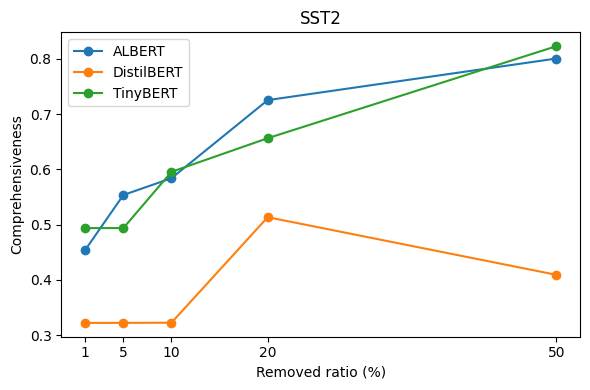


=== Processing IMDB ===

===== Running comprehensiveness for TinyBERT (IMDB) =====


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]



===== Running comprehensiveness for DistilBERT (IMDB) =====


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]



===== Running comprehensiveness for ALBERT (IMDB) =====


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]

       p  comp_mean       model
0   0.01   0.047225    TinyBERT
1   0.05   0.085656    TinyBERT
2   0.10   0.016006    TinyBERT
3   0.20   0.105452    TinyBERT
4   0.50   0.119802    TinyBERT
5   0.01  -0.000190  DistilBERT
6   0.05   0.000278  DistilBERT
7   0.10   0.001814  DistilBERT
8   0.20   0.206490  DistilBERT
9   0.50   0.383591  DistilBERT
10  0.01   0.000452      ALBERT
11  0.05   0.094619      ALBERT
12  0.10   0.374921      ALBERT
13  0.20   0.338178      ALBERT
14  0.50   0.125629      ALBERT
Figure saved to eval_plot/IMDB_comprehensiveness.png


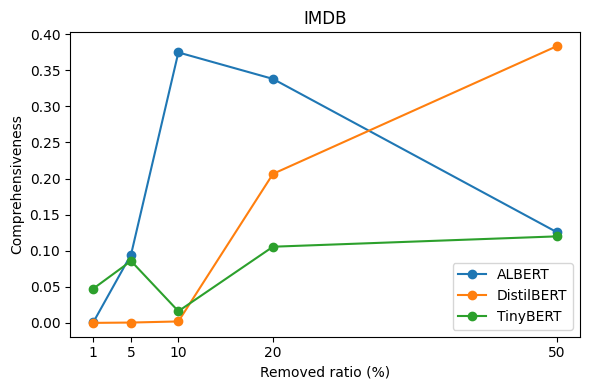

In [6]:
# --- Run comprehensiveness for all datasets ---
get_importance_fn = get_attention_score  # or get_lime_score, etc.

for dataset_name, cfg in datasets.items():
    print(f"\n=== Processing {dataset_name} ===")
    all_results = []

    for model_name, model_dir in cfg["models"].items():
        print(f"\n===== Running comprehensiveness for {model_name} ({dataset_name}) =====")

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)
        model.to(device).eval()

        comp_df = comprehensiveness(
            cfg["data"],
            tokenizer,
            model,
            get_importance_fn,
            RATIOS,
            device,
        )

        comp_df["model"] = model_name
        comp_df.rename(columns={"ratio": "p"}, inplace=True)  # keep 'p' consistent with stability
        all_results.append(comp_df)

    final_comp = pd.concat(all_results, ignore_index=True)
    print(final_comp)
    plot_comprehensiveness(final_comp, RATIOS, title=dataset_name)

# Suffiency


=== Processing SST2 ===

===== Running sufficiency for TinyBERT (SST2) =====


100%|██████████| 5/5 [00:00<00:00, 16.83it/s]



===== Running sufficiency for DistilBERT (SST2) =====


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]



===== Running sufficiency for ALBERT (SST2) =====


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

       p  suff_mean       model
0   0.01   0.257012    TinyBERT
1   0.05   0.257012    TinyBERT
2   0.10   0.296391    TinyBERT
3   0.20   0.179694    TinyBERT
4   0.50   0.010187    TinyBERT
5   0.01   0.416257  DistilBERT
6   0.05   0.416257  DistilBERT
7   0.10   0.111288  DistilBERT
8   0.20   0.186254  DistilBERT
9   0.50   0.068418  DistilBERT
10  0.01   0.551077      ALBERT
11  0.05   0.480775      ALBERT
12  0.10   0.461839      ALBERT
13  0.20   0.507221      ALBERT
14  0.50   0.173471      ALBERT
Figure saved to eval_plot/SST2_sufficiency.png


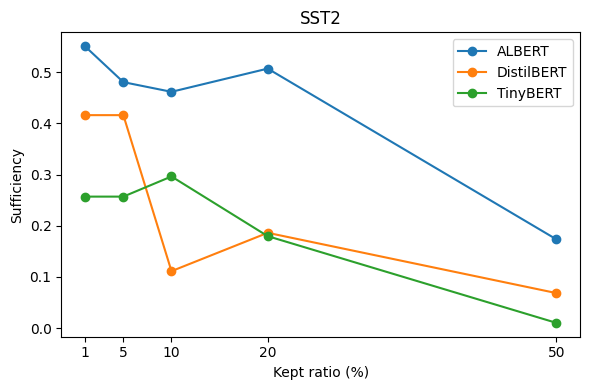


=== Processing IMDB ===

===== Running sufficiency for TinyBERT (IMDB) =====


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]



===== Running sufficiency for DistilBERT (IMDB) =====


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]



===== Running sufficiency for ALBERT (IMDB) =====


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

       p  suff_mean       model
0   0.01   0.282438    TinyBERT
1   0.05   0.410527    TinyBERT
2   0.10   0.371486    TinyBERT
3   0.20   0.087857    TinyBERT
4   0.50   0.062614    TinyBERT
5   0.01   0.497239  DistilBERT
6   0.05   0.264829  DistilBERT
7   0.10   0.176254  DistilBERT
8   0.20   0.026066  DistilBERT
9   0.50   0.180863  DistilBERT
10  0.01   0.491592      ALBERT
11  0.05   0.042131      ALBERT
12  0.10   0.001289      ALBERT
13  0.20  -0.000215      ALBERT
14  0.50   0.000166      ALBERT
Figure saved to eval_plot/IMDB_sufficiency.png


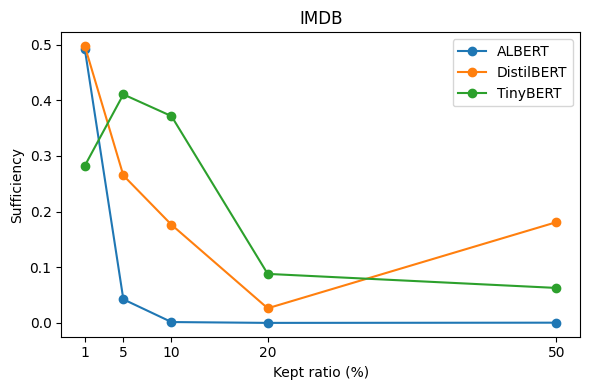

In [7]:
get_importance_fn = get_attention_score  # or get_lime_score

for dataset_name, cfg in datasets.items():
    print(f"\n=== Processing {dataset_name} ===")
    all_results = []

    for model_name, model_dir in cfg["models"].items():
        print(f"\n===== Running sufficiency for {model_name} ({dataset_name}) =====")

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True).to(device).eval()

        suff_df = sufficiency(
            cfg["data"],
            tokenizer,
            model,
            get_importance_fn,
            RATIOS,
            device,
        )

        suff_df["model"] = model_name
        suff_df.rename(columns={"ratio": "p"}, inplace=True)
        all_results.append(suff_df)

    final_suff = pd.concat(all_results, ignore_index=True)
    print(final_suff)
    plot_sufficiency(final_suff, RATIOS, title=dataset_name)
